# Get Calibration Data

In [102]:
import json
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [111]:
file_path = "../../../data/CE_data/06_02_24_Calibration_curve_phenol/chromatography_data.json"

compound_to_calibrate = "Nitro_Phenol"
calibration_compound = "PABA"

concentrations = [
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 0.1,  0.2,  0.5,  1.  ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 0.1,  0.2,  0.5,  1.  ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 0.1,  0.2,  0.5,  1.  ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 0.1,  0.2,  0.5,  1.  ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 2. ,  5. , 10. ,  10. ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 2. ,  5. , 10. ,  10. ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 2. ,  5. , 10. ,  10. ],
    [ 0.0, 0.1,  0.2,  0.5,  1. ,  2. ,  5. , 10. , 2. ,  5. , 10. ,  10. ]
]

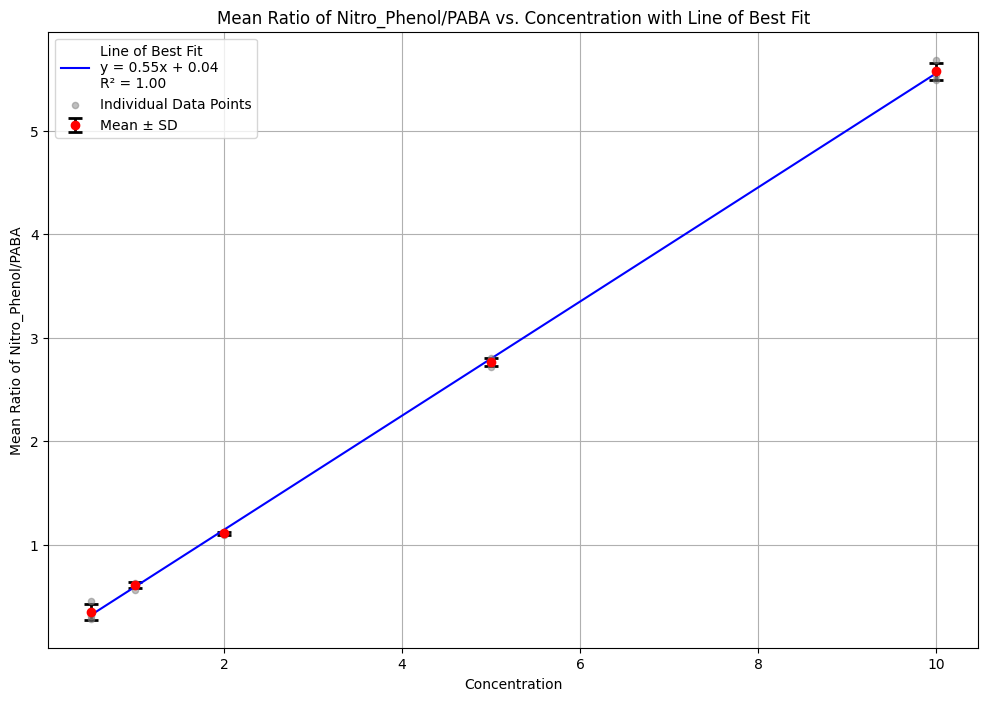

In [112]:
def well_to_array_position(well_id):
    """
    Maps a well ID in the format {A-H}{1-12} to its position in the 2D array.

    Args:
    - well_id (str): The well ID, e.g., "A1", "B12".

    Returns:
    - tuple: A tuple (row, column) indicating the well's position in the 2D array.
    """
    # Mapping from letter to row index (A=0, B=1, ..., H=7)
    row_map = {
        "A": 0, "B": 1, "C": 2, "D": 3,
        "E": 4, "F": 5, "G": 6, "H": 7
    }
    row = row_map[well_id[0]]  # First character indicates the row
    column = int(well_id[1:]) - 1  # Remaining characters indicate the column, adjusted by -1 for 0-based indexing

    return (row, column)

def get_concentration(well_id):
    # Use the function to get the array position
    row, column = well_to_array_position(well_id)
    
    # Access and return the concentration value from the array
    return concentrations[row][column]
    
with open(file_path, 'r') as file:
    data = json.load(file)

well_compounds = []
compounds_required = [compound_to_calibrate,calibration_compound]

for well, well_data in data.items():
    peaks = well_data["peaks"]
    compounds_in_well = [peak["compound"] for peak in peaks]
    if all(compound in compounds_in_well for compound in compounds_required):
        compound_area = next(peak["peak_area"] for peak in peaks if peak["compound"] == compound_to_calibrate)
        calibration_area = next(peak["peak_area"] for peak in peaks if peak["compound"] == calibration_compound)
        
        # Save the areas and well information
        well_compounds.append( [compound_area, calibration_area, get_concentration(well)])

# print(well_compounds)

# Grouping ratios by concentration
ratios_by_concentration = {}
for info in well_compounds:
    concentration = info[2]
    ratio = info[0] / info[1]
    if concentration not in ratios_by_concentration:
        ratios_by_concentration[concentration] = []
    ratios_by_concentration[concentration].append(ratio)

# Calculating mean and standard deviation for each concentration
mean_ratios = [np.mean(ratios) for ratios in ratios_by_concentration.values()]
std_devs = [np.std(ratios) for ratios in ratios_by_concentration.values()]
concentration_values = list(ratios_by_concentration.keys())
# Calculating the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(concentration_values, mean_ratios)

# Line of best fit
line = [slope * x + intercept for x in concentration_values]

# Plotting with line of best fit and more prominent error bars
plt.figure(figsize=(12, 8))

# Error bars
plt.errorbar(concentration_values, mean_ratios, yerr=std_devs, fmt='o', color='red', ecolor='black', elinewidth=2, capsize=5, capthick=2, label='Mean ± SD')

# Line of best fit
plt.plot(concentration_values, line, 'b-', label=f'Line of Best Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}')
for concentration, ratios in ratios_by_concentration.items():
    plt.scatter([concentration] * len(ratios), ratios, color='gray', alpha=0.5, zorder=2, s=20, label='Individual Data Points' if concentration == list(ratios_by_concentration.keys())[0] else "")

plt.title(f'Mean Ratio of {compound_to_calibrate}/{calibration_compound} vs. Concentration with Line of Best Fit')
plt.xlabel('Concentration')
plt.ylabel(f'Mean Ratio of {compound_to_calibrate}/{calibration_compound}')
plt.grid(True)
plt.legend()
plt.show()